In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf, matplotlib.pyplot as plt, numpy as np, matplotlib.pyplot as plt, matplotlib.patches as patches
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from framework.utils import io_utils, train_utils

# Read Dataset

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
def read_tfrecord(example):
    tfrecord_format = {
        "filename": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    filename = tf.cast(example["filename"], tf.string)
    image = tf.io.parse_tensor(example["image"], tf.uint8)
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(example["label"], tf.int32)
    return {"filename": filename, "image": image, "label": label}

In [4]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames)  # automatically interleaves reads from multiple files
    dataset = dataset.map(read_tfrecord)
    dataset = dataset.with_options(ignore_order)  # uses data as soon as it streams in, rather than in its original order
    return dataset

In [5]:
def get_dataset(filenames, train=True):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [6]:
def read_label_map(label_map_path):
    item_id = None
    item_name = None
    items = {}

    with open(label_map_path, "r") as file:
        for line in file:
            line.replace(" ", "")
            if line == "item{":
                pass
            elif line == "}":
                pass
            elif "id" in line:
                item_id = int(line.split(":", 1)[1].strip())
            elif "name" in line:
                item_name = line.split(":", 1)[1].replace("'", "").replace("\"", "").strip()

            if item_id is not None and item_name is not None:
                items[item_name] = item_id
                item_id = None
                item_name = None

    return items

In [7]:
label_map_path = "./data_preparation/label_map.pbtxt"
label_map_dict = read_label_map(label_map_path)

print(label_map_dict)

{'pothole': 1, 'crack': 2}


In [8]:
def get_label_text(result, doc = label_map_dict):
    for key, value in doc.items():
        if(value == result + 1):
            return key
    return "Unpredictable"

In [9]:
train_data = get_dataset("./data_preparation/train_roi.tfrecord")
test_data = get_dataset("./data_preparation/test_roi.tfrecord", train=False)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


# Init Variable and Data

In [10]:
IMAGE_SIZE = (64, 64, 3)  # make sure had same size with the picture
epoch = 50

In [11]:
def split_to_own_list(list_data):
    images = []
    labels = []
    filenames = []
    for data in list_data:
        images.append(data["image"].numpy().reshape(*IMAGE_SIZE))
        labels.append(data["label"].numpy())
        filenames.append(str(data["filename"].numpy()).replace("b\'", "").replace("\'", ""))
    return np.array(filenames), np.array(images), np.array(labels)

In [12]:
train_filenames, train_images, train_labels = split_to_own_list(list(train_data))
test_filenames, test_images, test_labels = split_to_own_list(list(test_data))

train_labels = tf.keras.utils.to_categorical(train_labels, 2)
test_labels = tf.keras.utils.to_categorical(test_labels, 2)

# Train Model

In [13]:
backbone = "vgg16"
# backbone = "mobilenet_v2"
# backbone = "resnet50"

In [14]:
if (backbone == "vgg16"):
    from tensorflow.keras.applications.vgg16 import VGG16 as BaseModel
elif (backbone == "mobilenet_v2"):
    from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 as BaseModel
elif (backbone == "resnet50"):
    from tensorflow.keras.applications.resnet50 import ResNet50 as BaseModel

In [15]:
base_model = BaseModel(include_top = False, input_shape = IMAGE_SIZE)

augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape= IMAGE_SIZE, name="input_aug_flip"),
    tf.keras.layers.RandomRotation(0.5, name="aug_rotation")
], name="augmentation")

model = tf.keras.Sequential([
    augmentation,
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation= 'relu'),
    tf.keras.layers.Dense(4096, activation= 'relu'),
    tf.keras.layers.Dense(1000, activation= 'relu'),
    tf.keras.layers.Dense(2, activation= 'softmax')
], name=f"model_roi_{backbone}")

model.summary()

Model: "model_roi_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4096)              8392704   
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 1000)          

In [16]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.97):
            print("\nAccuracy value higher than or equal 97%, stop training!")
            self.model.stop_training = True

roi_model_path = io_utils.get_model_roi_path("roi", backbone)
checkpoint_callback = ModelCheckpoint(roi_model_path, monitor="accuracy")

In [17]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

step_size_train = train_utils.get_step_size(len(train_images), 1)
history = model.fit(train_images, train_labels, epochs = epoch, verbose=1,
                    steps_per_epoch = step_size_train,
                    callbacks = [myCallback(), checkpoint_callback])

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
595/595 [==============================] - 13s 16ms/step - loss: 0.4262 - accuracy: 0.8017
Epoch 2/50
595/595 [==============================] - 10s 16ms/step - loss: 0.1892 - accuracy: 0.9328
Epoch 3/50
595/595 [==============================] - 10s 16ms/step - loss: 0.1163 - accuracy: 0.9462
Epoch 4/50
595/595 [==============================] - 10s 16ms/step - lo

In [18]:
print("Evaluate")
result = model.evaluate(test_images, test_labels)
dict(zip(model.metrics_names, result))

Evaluate
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5/5 [==============================] - 1s 98ms/step - loss: 0.0408 - accuracy: 0.9936


{'loss': 0.04076295346021652, 'accuracy': 0.993630588054657}

In [19]:
print("Predict")
result = model.predict(test_images)
result

Predict
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


array([[9.99169469e-01, 8.30540259e-04],
       [1.23069913e-04, 9.99876857e-01],
       [9.99999285e-01, 7.21684614e-07],
       [6.39220962e-05, 9.99936104e-01],
       [6.41412407e-05, 9.99935865e-01],
       [9.99421120e-01, 5.78893698e-04],
       [1.75748230e-03, 9.98242497e-01],
       [9.99430001e-01, 5.69953525e-04],
       [9.99714196e-01, 2.85743125e-04],
       [9.99982953e-01, 1.70418680e-05],
       [9.99073505e-01, 9.26462526e-04],
       [9.93195057e-01, 6.80495333e-03],
       [9.99998808e-01, 1.13487727e-06],
       [9.89777148e-01, 1.02228103e-02],
       [3.84286504e-05, 9.99961615e-01],
       [3.18608130e-03, 9.96813953e-01],
       [2.59906612e-03, 9.97400999e-01],
       [4.27698920e-04, 9.99572337e-01],
       [3.46240733e-04, 9.99653816e-01],
       [9.99888539e-01, 1.11413996e-04],
       [1.90306157e-02, 9.80969429e-01],
       [9.99702752e-01, 2.97184219e-04],
       [9.99999762e-01, 2.80017559e-07],
       [9.99735296e-01, 2.64637958e-04],
       [1.990893

In [20]:
def show_data(images, labels, filenames):
    plt.figure(figsize=(10, 10))
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i] / 255.0)
        plt.xlabel(get_label_text(labels[i]))
        plt.xticks([])

In [21]:
def predict_to_label(predict):
    result = []
    for i in predict:
        result.append(np.argmax(i))
    return np.array(result)

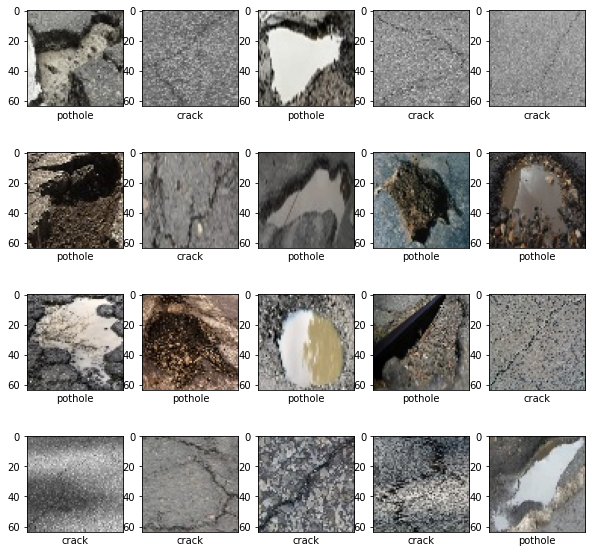

In [22]:
predict_result = predict_to_label(result)

show_data(test_images * 255, predict_result, test_filenames)